In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import copy

In [4]:
folder = 'data/'
state = 'fl_statewide_2020_04_01.csv'
state2 = 'ca_long_beach_2020_04_01.csv'

# Preprocessing whole dataset (do not execute if working on full data)

In [5]:
df_full = pd.read_csv(folder + state)
print(df_full.columns)

Index(['raw_row_number', 'date', 'time', 'location', 'county_name',
       'subject_age', 'subject_race', 'subject_sex', 'officer_id_hash',
       'officer_age', 'officer_race', 'officer_sex',
       'officer_years_of_service', 'department_name', 'unit', 'type',
       'violation', 'arrest_made', 'citation_issued', 'warning_issued',
       'outcome', 'frisk_performed', 'search_conducted', 'search_basis',
       'reason_for_search', 'reason_for_stop', 'vehicle_registration_state',
       'notes', 'raw_row_number_old', 'raw_Race', 'raw_Ethnicity',
       'raw_row_number_new', 'raw_SearchType', 'raw_EnforcementAction'],
      dtype='object')


Reducing the amount of data for experimentation

In [6]:
cut_file_path = folder + state.split('.')[0] + "_cut.csv"
total_size = df_full.shape[0]
df = df_full.sample(n=int(total_size/100))
print("Full dataset of size {} was reduced to subset of {} elements.".format(total_size, df.shape[0]))
df.to_csv(cut_file_path, index = False)

Full dataset of size 7297538 was reduced to subset of 72975 elements.


# Load the data (currently loading all data)

In [7]:
df =  pd.read_csv(folder + state)
print("Dataset is composed of {} stops. Columns are: \n".format(df.shape[0]))
for col in df.columns:
    if df.dtypes[col] != np.float64:
        val = df[col].unique()
        if len(val) > 20:
            print('{} \t\t: too much different values'.format(col))
        else:
            print('{} \t\t: values are: {}'.format(col if len(col)>15 else col + "\t\t", val))
df = df.rename(columns={'officer_years_of_service': 'officer_yos'})

Dataset is composed of 7297538 stops. Columns are: 

raw_row_number 		: too much different values
date 		: too much different values
time 		: too much different values
location 		: too much different values
county_name 		: too much different values
subject_race		 		: values are: [nan 'white' 'black' 'hispanic' 'asian/pacific islander' 'other' 'unknown']
subject_sex		 		: values are: ['female' 'male' nan]
officer_id_hash 		: too much different values
officer_race		 		: values are: [nan 'black' 'white' 'hispanic' 'unknown' 'asian/pacific islander' 'other']
officer_sex		 		: values are: [nan 'male' 'female']
department_name		 		: values are: ['FLORIDA HIGHWAY PATROL' 'FLORIDA HIGHWAY PATROL - TROOP K'
 'FLORIDA HIGHWAY PATROL  MOTORS SQ' 'FLORIDA DEPARTMENT OF AGRICULTURE'
 nan]
unit 		: too much different values
type		 		: values are: ['vehicular']
violation 		: too much different values
arrest_made		 		: values are: [nan False True]
citation_issued		 		: values are: [True False nan]
war

# Preprocess to compare search rates

Calculate search rates for each officer race and each subject race across each county

# General functions

In [8]:
minority_race = ['black', 'hispanic']

def remove_general_unused_columns(data):
    columns_unused = ['officer_id_hash', 'vehicle_registration_state', 'type']
    columns_reasons = ['reason_for_stop', 'reason_for_search', 'notes', 'violation', 'search_basis']
    columns_raw = ['raw_EnforcementAction', 'raw_SearchType', 'raw_Ethnicity', 'raw_row_number_new', 'raw_Race', 'raw_row_number_old', 'raw_row_number']
    columns_geography = ['location', 'date','time', 'department_name', 'unit']
    return data.drop(columns=columns_unused + columns_reasons + columns_raw + columns_geography)

def print_search_rate(data):
    number_stops = data['search_conducted'].shape[0]
    number_search_conducted = data[data['search_conducted'] == True].shape[0]
    print('Data contains {} stops and {} of them ({}%) resulted in searches.'.format(number_stops, number_search_conducted, 100 * float(number_search_conducted)/number_stops))

def preprocess_for_grouping(data):
    data['search_rate'] = data['search_conducted']
    data = data.astype({'search_rate': float})
    data['count'] = 1 # to count occurences
    return data

def separate_data(data, categories):
    df = {}
    for exp in categories:
        df[exp] = data.loc[exp]
    return df


In [109]:
from scipy.stats import linregress

def plot_race(data, min_race, categories, threshold, what_to_plot):

    fig, ax_arr = plt.subplots(1, 3) # 2 graphs
    fig.set_size_inches(14,5) # fig size
    fig.suptitle(min_race.title() + " people search rates among officers".format(min_race))

    for i, off_feat in enumerate(categories):

        data_ = data[off_feat]
        df_white_sub, df_minority = data_.loc['white'], data_.loc[min_race] #separate data
        df_white_sub.reset_index(inplace=True), df_minority.reset_index(inplace=True) #reset index
        df_merged = pd.merge(df_white_sub, df_minority, on='county_name', suffixes=['_white', '_minority']) # merge both

        # remove where there are too little datapoints
        cond_minority = df_merged['count_minority'] >= threshold

        x = df_merged[what_to_plot + '_white'][cond_minority]*100
        y = df_merged[what_to_plot + '_minority'][cond_minority]*100
        s = df_merged['count_minority'][cond_minority]/100

        ax_arr[i].scatter(x, y, s=s, c="None", edgecolors='black', linewidth=0.4)
        ax_arr[i].set_xlabel("White " + what_to_plot + " (%)")
        ax_arr[i].set_ylabel(min_race.title() + " "+ what_to_plot +" (%)")

        #plot regression
        a, b, r, p_value, std_err = linregress(x, y)
        sns.regplot(x=x.repeat(s), y=y.repeat(s), ax=ax_arr[i], label='{:.1f}*x + {:.1f}, r={:.2f}'.format(a,b,r), scatter=False).legend(loc="best")

        ax_arr[i].set_title(off_feat.title() +' officers')

        if what_to_plot == 'search_rate':
            # draw dotted line
            max_ = df_merged[what_to_plot + '_minority'][cond_minority].max()
            line = np.arange(0, max_ * 100, max_)
            ax_arr[i].plot(line, line, c='black', linestyle=(0,(5,5)), linewidth=1)


def plot_search_rates(data, categories, threshold=500, what_to_plot='search_rate'):
    for race in minority_race:
        plot_race(data, race, categories, threshold, what_to_plot)

# Race of officer

In [10]:
officer_race = ['white', 'black', 'hispanic']

In [82]:
df_race = copy(df)

# remove unused columns
df_race = remove_general_unused_columns(df_race)

# make sure that required data are present (drop if nan values in those columns)
important_features = ['subject_race', 'officer_race', 'search_conducted']
df_race.dropna(inplace=True, subset=important_features)
print('Cleaned subset is composed of {} datapoints'.format(df_race.shape[0]))

# overview of all the data / global search rate
print_search_rate(df_race)

# preprocess for grouping
df_race = preprocess_for_grouping(df_race)

# add specific column for this type of analyzis
df_race_all = df_race.groupby(['officer_race','subject_race','county_name']).agg({'search_rate': 'mean', 'count':'count'})

Cleaned subset is composed of 4191965 datapoints
Data contains 4191965 stops and 25708 of them (0.6132684791022825%) resulted in searches.


search_rate  \
officer_race           subject_race           county_name                        
asian/pacific islander asian/pacific islander Broward County               0.0   
                                              Escambia County              0.0   
                                              Gadsden County               0.0   
                                              Hillsborough County          0.0   
                                              Indian River County          0.0   

                                                                   count  
officer_race           subject_race           county_name                 
asian/pacific islander asian/pacific islander Broward County           9  
                                              Escambia County         38  
                                              Gadsden County           1  
                                              Hillsborough County     38  
                                              Indian River County      5

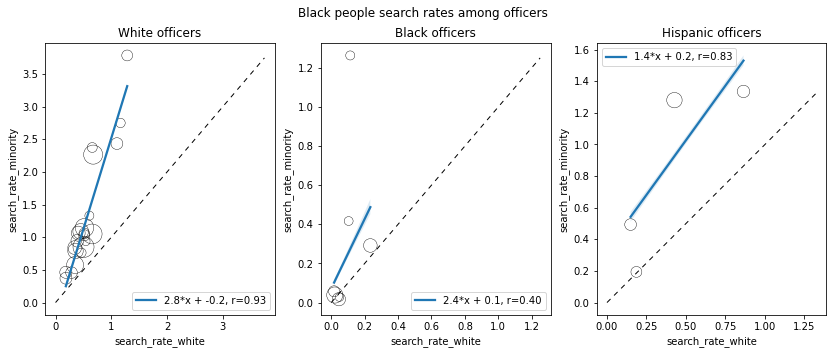

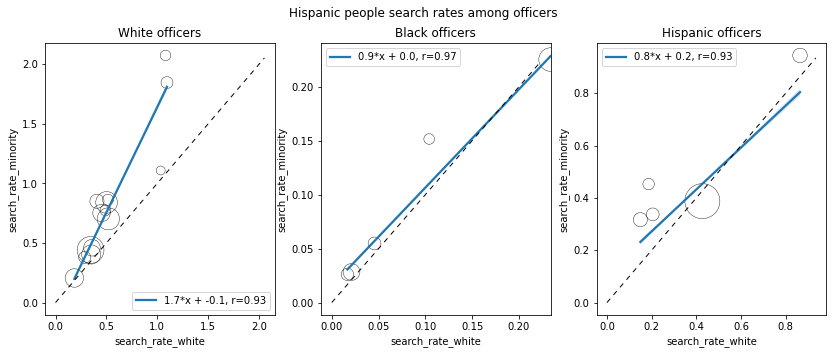

In [114]:
# separate data
df_race_sep = separate_data(df_race_all, officer_race)
df_race_sep[officer_race[0]].head(2)

# plot it 
plot_search_rates(df_race_sep, officer_race, 7000)

# Experience of officer

In [13]:
officer_experience_level = ['young', 'experienced', 'old']
thresholds_experience = [2, 9]

Preprocess the data to have what is needed

In [14]:
df_yos = copy(df)

# remove unused columns
df_yos = remove_general_unused_columns(df_yos)

# make sure that required data are present (drop if nan values in those columns)
important_features = ['subject_race', 'officer_yos', 'search_conducted']
df_yos.dropna(inplace=True, subset=important_features)
print('Cleaned subset is composed of {} datapoints'.format(df_yos.shape[0]))

# overview of all the data / global search rate
print_search_rate(df_yos)

# preprocess for grouping
df_yos = preprocess_for_grouping(df_yos)

# add specific column for this type of analyzis
df_yos['age_category'] = df_yos['officer_yos'].apply(lambda x : officer_experience_level[0] if x < thresholds_experience[0] else (officer_experience_level[1] if x < thresholds_experience[1] else officer_experience_level[2]))
df_yos_all = df_yos.groupby(['age_category','subject_race','county_name']).agg({'search_rate': 'mean', 'count':'count'})

Cleaned subset is composed of 4995855 datapoints
Data contains 4995855 stops and 28712 of them (0.5747164399287009%) resulted in searches.


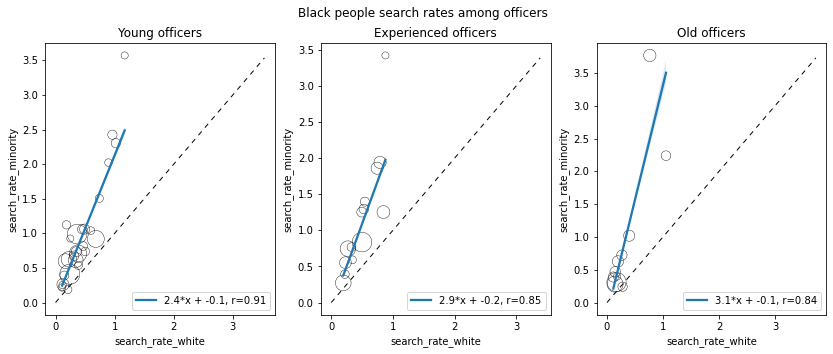

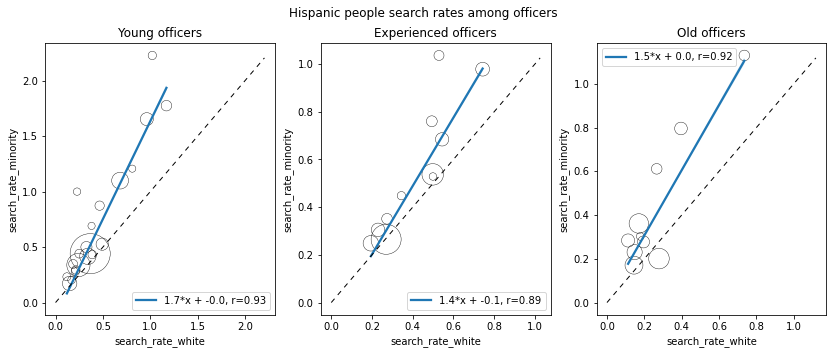

In [115]:
# separate data
df_yos_sep = separate_data(df_yos_all, officer_experience_level)
df_yos_sep[officer_experience_level[0]].head(2)

# plot it 
plot_search_rates(df_yos_sep, officer_experience_level, 5000)

# Age of the officer

In [16]:
officer_age_level = ['young', 'experienced', 'old']
thresholds_age = [30, 50]

In [17]:
df_age = copy(df)

# remove unused columns
df_age = remove_general_unused_columns(df_age)

# make sure that required data are present (drop if nan values in those columns)
important_features = ['subject_race', 'officer_age', 'search_conducted']
df_age.dropna(inplace=True, subset=important_features)
print('Cleaned subset is composed of {} datapoints'.format(df_age.shape[0]))

# overview of all the data / global search rate
print_search_rate(df_age)

# preprocess for grouping
df_age = preprocess_for_grouping(df_age)

# add specific column for this type of analyzis
df_age['age_category'] = df_age['officer_age'].apply(lambda x : officer_age_level[0] if x < thresholds_age[0] else (officer_age_level[1] if x < thresholds_age[1] else officer_age_level[2]))
df_age_all = df_age.groupby(['age_category','subject_race','county_name']).agg({'search_rate': 'mean', 'count':'count'})

Cleaned subset is composed of 4423122 datapoints
Data contains 4423122 stops and 26619 of them (0.6018147362880789%) resulted in searches.


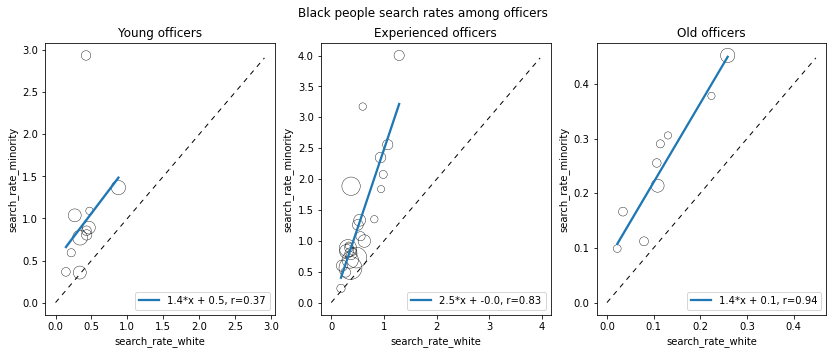

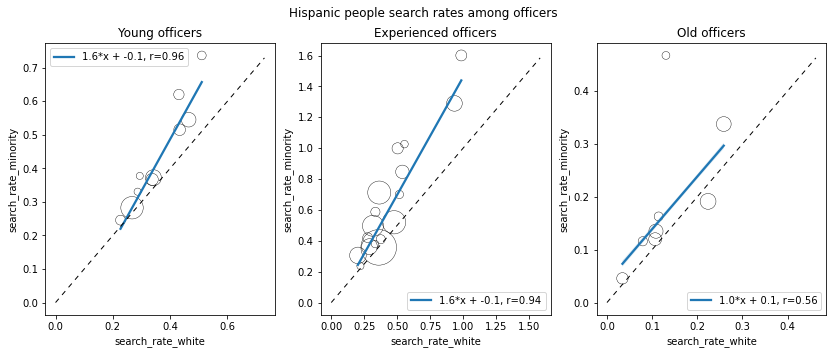

In [116]:
# separate data
df_age_sep = separate_data(df_age_all, officer_age_level)
df_age_sep[officer_age_level[0]].head(2)

# plot it 
plot_search_rates(df_age_sep, officer_age_level, 5000)

# Race of the officer (with stop_rate)

In [30]:
officer_race = ['white', 'black', 'hispanic']

In [118]:
# make sure that required data are present (drop if nan values in those columns)
important_features = ['subject_race', 'officer_race', 'search_conducted']
df_race.dropna(inplace=True, subset=important_features)
print('Cleaned subset is composed of {} datapoints'.format(df_race.shape[0]))

# overview of all the data / global search rate
print_search_rate(df_race)


# add specific column for this type of analyzis
df_race_all_s = df_race.groupby(['officer_race','county_name', 'subject_race']).agg({'count':'count'})
df_race_all = df_race.groupby(['officer_race','county_name']).agg({'count':'count'})

df_race_mixed = copy(df_race_all_s)
df_race_mixed['tot'] = df_race_all['count']
df_race_mixed['stop_rate'] = df_race_mixed['count'] / df_race_mixed['tot']

df_race_mixed = df_race_mixed.reorder_levels(['officer_race','subject_race','county_name'])
# df_race_mixed.head()

Cleaned subset is composed of 4191965 datapoints
Data contains 4191965 stops and 25708 of them (0.6132684791022825%) resulted in searches.


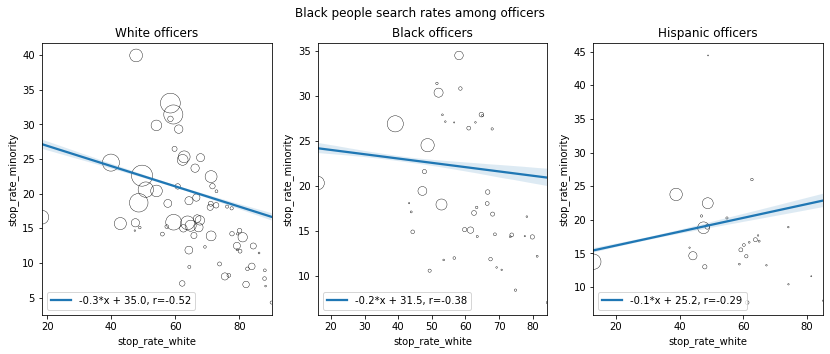

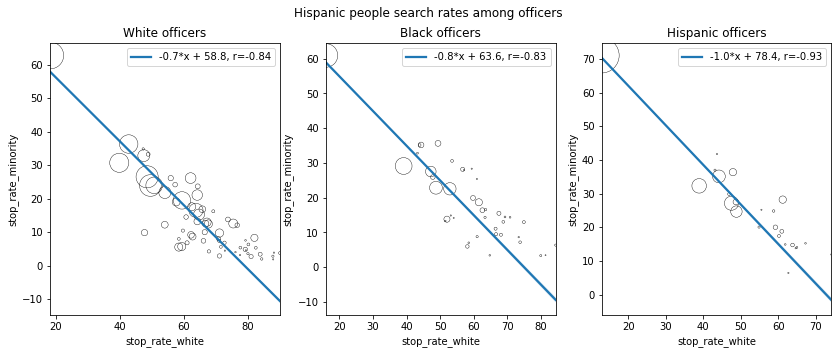

In [119]:
# separate data
df_race_sep = separate_data(df_race_mixed, officer_race)
df_race_sep[officer_race[0]].head(2)

# plot it 
plot_search_rates(df_race_sep, officer_race, 100, what_to_plot='stop_rate')

# Logistic regression of characteristics of officers

In [19]:
df_log_raw = copy(df)

# remove unused columns
df_log_raw = remove_general_unused_columns(df_log_raw)
df_log_raw.drop(columns=['arrest_made', 'citation_issued','warning_issued', 'outcome', 'frisk_performed'], inplace=True)
df_log_raw.dropna(inplace=True, subset=['search_conducted'])

# make sure that required data are present (drop if nan values in those columns)
important_features = ['subject_age', 'officer_yos', 'officer_age']
for feat in important_features:
    m = df_log_raw[feat].mean()
    df_log_raw[feat] = df_log_raw[feat].fillna((m))
print('Cleaned subset is composed of {} datapoints'.format(df_log_raw.shape[0]))

# overview of all the data / global search rate
print_search_rate(df_log_raw)

df_log_raw.head()

Cleaned subset is composed of 4997635 datapoints
Data contains 4997635 stops and 28732 of them (0.5749119333444719%) resulted in searches.


,county_name,subject_age,subject_race,subject_sex,officer_age,officer_race,officer_sex,officer_yos,search_conducted
1,Duval County,23.0,white,female,31.0,black,male,8.0,False
2,Duval County,45.0,white,female,29.0,white,male,3.0,False
3,St. Lucie County,41.0,white,male,26.0,white,male,3.0,False
6,Gadsden County,26.0,white,male,47.0,white,male,0.0,False
7,Gadsden County,42.0,hispanic,male,47.0,white,male,0.0,True


In [20]:
# preprocess for regression
df_log = copy(df_log_raw)

print('Processing sub races')
sub_races = list(df_log['subject_race'].unique())
for race in sub_races:
    df_log['subject_' + (race if isinstance(race, str) else 'nan')] = (df_log['subject_race'] == race).apply(lambda x : int(x))

print('Processing off races')
off_races = list(df_log['officer_race'].unique())
for race in off_races:
    df_log['officer_' + (race if isinstance(race, str) else 'nan')] = (df_log['officer_race'] == race).apply(lambda x : int(x))

print('Processing sub genders')
sub_genders = list(df_log['subject_sex'].unique())
for gender in sub_genders:
    df_log['subject_' + (gender if isinstance(gender, str) else 'nan')] = (df_log['subject_sex'] == gender).apply(lambda x : int(x))

print('Processing off genders')
off_genders = list(df_log['officer_sex'].unique())
for gender in off_genders:
    df_log['officer_' + (gender if isinstance(gender, str) else 'nan')] = (df_log['officer_sex'] == gender).apply(lambda x : int(x))

print('Processing off yos')
cat_exp = [0, 2, 6, 10, 15, 100]
for infi in range(len(cat_exp) -1):
    df_log['officer_exp_' + str(cat_exp[infi]) ] = ( df_log['officer_yos'].between(cat_exp[infi],cat_exp[infi+1], inclusive=[True, False]) ) .apply(lambda x : int(x))

print('Processing off age')
cat_age = [15, 25, 35, 45, 55, 70, 100]
for infi in range(len(cat_age) -1):
    df_log['officer_age_' + str(cat_age[infi]) ] = ( df_log['officer_age'].between(cat_age[infi],cat_age[infi+1], inclusive=[True, False]) ) .apply(lambda x : int(x))


print('Processing search')
df_log['search_conducted'] = df_log['search_conducted'].apply(lambda x : int(x))

print('Removing old columns')
df_log.drop(columns=['subject_race', 'officer_race', 'subject_sex', 'officer_sex', 'officer_yos', 'officer_age'], inplace=True)

df_log.head()

Processing sub races
Processing off races
Processing sub genders
Processing off genders
Processing off yos
Processing off age
Processing search
Removing old columns


,county_name,subject_age,search_conducted,subject_white,subject_hispanic,subject_black,subject_asian/pacific islander,subject_other,subject_nan,officer_black,...,officer_exp_2,officer_exp_6,officer_exp_10,officer_exp_15,officer_age_15,officer_age_25,officer_age_35,officer_age_45,officer_age_55,officer_age_70
1,Duval County,23.0,0,1,0,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0
2,Duval County,45.0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
3,St. Lucie County,41.0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
6,Gadsden County,26.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7,Gadsden County,42.0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [21]:
counties = df_log['county_name'].unique()
maxi = 0
maxi_c = 0
for c in counties:
    v = df_log[df_log['county_name'] == c].shape[0]
    if v > maxi:
        maxi = v
        maxi_c = c

print(maxi_c, maxi )

df_log = df_log[df_log['county_name'] == maxi_c].drop(columns='county_name')

Miami-Dade County 441572


In [22]:
df_log.head()

,subject_age,search_conducted,subject_white,subject_hispanic,subject_black,subject_asian/pacific islander,subject_other,subject_nan,officer_black,officer_white,...,officer_exp_2,officer_exp_6,officer_exp_10,officer_exp_15,officer_age_15,officer_age_25,officer_age_35,officer_age_45,officer_age_55,officer_age_70
40274,27.0,0,0,1,0,0,0,0,0,1,...,0,1,1,0,0,0,0,1,0,0
40316,48.0,0,1,0,0,0,0,0,0,1,...,0,1,1,0,0,0,0,1,0,0
40361,37.0,0,0,1,0,0,0,0,0,1,...,0,1,1,0,0,0,0,1,0,0
40414,29.0,0,0,1,0,0,0,0,0,1,...,0,1,1,0,0,0,0,1,0,0
40441,34.0,0,0,1,0,0,0,0,0,1,...,0,1,1,0,0,0,0,1,0,0


In [23]:
y = df_log['search_conducted'].to_numpy()
x = df_log.drop(columns='search_conducted').to_numpy()
print(x[0], y[0])

[27.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  1.  0.
  0.  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.] 0


In [24]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0)
clf.fit(x, y)
params = clf.coef_[0]

In [25]:
print("Parameters of logistic regression are:")
for i, col in enumerate(df_log.drop(columns='search_conducted').columns):
    print(" - {} : {:.3f} ".format(col,params[i]))

Parameters of logistic regression are:
 - subject_age : -0.054 
 - subject_white : -0.725 
 - subject_hispanic : -0.691 
 - subject_black : 0.228 
 - subject_asian/pacific islander : -0.618 
 - subject_other : -0.712 
 - subject_nan : 0.000 
 - officer_black : -0.652 
 - officer_white : 0.178 
 - officer_nan : 0.000 
 - officer_hispanic : 0.257 
 - officer_unknown : -0.158 
 - officer_asian/pacific islander : -0.037 
 - officer_other : -0.021 
 - subject_female : -1.069 
 - subject_male : -0.063 
 - officer_male : -0.040 
 - officer_female : -1.936 
 - officer_exp_0 : 0.051 
 - officer_exp_2 : -0.651 
 - officer_exp_6 : 0.030 
 - officer_exp_10 : -0.194 
 - officer_exp_15 : -1.182 
 - officer_age_15 : -0.253 
 - officer_age_25 : -0.404 
 - officer_age_35 : -0.059 
 - officer_age_45 : -0.877 
 - officer_age_55 : -1.805 
 - officer_age_70 : -0.001 


In [26]:
from xgboost import XGBClassifier, plot_importance, DMatrix

model = XGBClassifier()
model.fit(x, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

[Text(0, 0, 'subject_age'),
 Text(0, 1, 'subject_white'),
 Text(0, 2, 'subject_hispanic'),
 Text(0, 3, 'subject_black'),
 Text(0, 4, 'subject_asian/pacific islander'),
 Text(0, 5, 'subject_other'),
 Text(0, 6, 'subject_nan'),
 Text(0, 7, 'officer_black'),
 Text(0, 8, 'officer_white'),
 Text(0, 9, 'officer_nan'),
 Text(0, 10, 'officer_hispanic'),
 Text(0, 11, 'officer_unknown'),
 Text(0, 12, 'officer_asian/pacific islander'),
 Text(0, 13, 'officer_other'),
 Text(0, 14, 'subject_female'),
 Text(0, 15, 'subject_male'),
 Text(0, 16, 'officer_male'),
 Text(0, 17, 'officer_female'),
 Text(0, 18, 'officer_exp_0'),
 Text(0, 19, 'officer_exp_2'),
 Text(0, 20, 'officer_exp_6'),
 Text(0, 21, 'officer_exp_10'),
 Text(0, 22, 'officer_exp_15')]

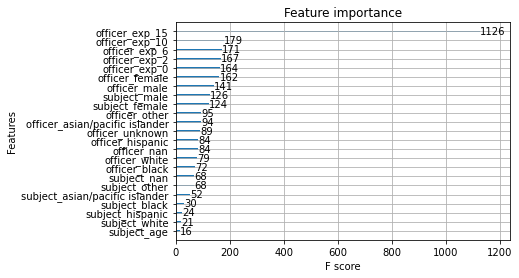

In [27]:
plot_importance(model).set_yticklabels(df_log.drop(columns='search_conducted').columns[:23])

We see that experienced officers do not search often people. This may be due because they are at a higher level, so they do not do the search themselves. 

# Old stuff

In [28]:
def plot_officer_race(data, race):
    data_ = data[race]
    df_white_sub, df_black_sub, df_hispanic = data_.loc['white'], data_.loc['black'], data_.loc['hispanic'] #separate data
    df_white_sub.reset_index(inplace=True), df_black_sub.reset_index(inplace=True), df_hispanic.reset_index(inplace=True) #reset index
    df_merged = pd.merge(df_white_sub, df_black_sub, on='county_name', suffixes=['', '_black'])
    df_merged = pd.merge(df_merged, df_hispanic, on='county_name', suffixes=['_white', '_hispanic'])
    fig, ax_arr = plt.subplots(1, 2) # 2 graphs
    fig.set_size_inches(9,5) # fig size

    fig.suptitle("Minorities search rates of {} officers".format(race))

    ax_arr[0].scatter(df_merged['search_rate_white']*100, df_merged['search_rate_black']*100)
    ax_arr[0].set_xlabel("White search rate (%)")
    ax_arr[0].set_ylabel("Black search rate (%)")

    ax_arr[1].scatter(df_merged['search_rate_white']*100, df_merged['search_rate_hispanic']*100)
    ax_arr[1].set_xlabel("White search rate (%)")
    ax_arr[1].set_ylabel("Black search rate (%)")
    

for race in officer_race:
    plot_officer_race(df_officers, race)

NameError: name 'df_officers' is not defined